# Notebook Tauro: visualización de vectores con PCA / t-SNE (inglés)

In [89]:
import pandas as pd
import re
from nltk.corpus import stopwords 
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
from matplotlib import pyplot
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import en_core_web_lg
import tensorflow as tf
import gensim
import os
from tensorflow.contrib.tensorboard.plugins import projector
import warnings
nlp = en_core_web_lg.load()
%matplotlib inline

# Apertura del archivo con letras en inglés

In [200]:
print ('Archivo de input cargado df_darklyrics_en.pkl\n\n')
df_en = pd.read_pickle("./archivos_modelos/df_darklyrics_en.pkl")
stoplist = list(stopwords.words('english'))
documents = df_en.lyric
documents.replace('', np.nan, inplace=True)
documents.dropna(inplace=True)

Archivo de input cargado df_darklyrics_en.pkl




In [198]:
#df_en = pd.read_pickle("./archivos_modelos/df_darklyrics_en.pkl")
#df_en.to_csv('./letrasingles.csv')

In [201]:
documents

0         New times Disguise falling Of planners behind ...
2         Dismal life of torment Ripping at my body Horr...
3         In bitterness and repugnance I've passed the p...
4         Beloved children missing Swallowed in obscurit...
5         Destitute and unwanted Departing from asylum L...
6         Urethra corded up (While) wine is infused in l...
7         Delightfully dripping from above as I wallow i...
8         Human creativity Spawning amorality Altruism a...
9         Moments of unspeakable suffering affecting my ...
10        Victim Beaten Torn And Raped. Unwanted Interco...
11        Miserable Species Of Vanity Forming Thoughts O...
12        Duplicating Human Cruelty By Order of The High...
13        Ability of Free Thought Destroyed in Early Inf...
14        Animals Driven by Their Instinct Having Killed...
15        Illusions Of Superiority Brutally Crushed by T...
16        Frozen lifeless bodies, scattered on the stree...
17        Human Sanity Extremely Weak Th

# Tokenización y filtrado de documentos vacíos

In [202]:
def cleaning(doc):
	txt = [token.lemma_ for token in doc if not token.is_stop]    
	txt = [x for x in txt if x not in stoplist]   
	return txt

In [203]:
print ('Tokenizando y filtrando documentos... puede tomar 1 hora o más')
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in documents)
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print ('Documentos tokenizados y filtrados')

Tokenizando y filtrando documentos... puede tomar 1 hora o más
Documentos tokenizados y filtrados


# Entrenamiento del modelo de word embeddings con documentos

In [204]:
print ('Ejecutando modelo de word2vec... puede tomar 1 hora o más')
model = Word2Vec(txt, size=300, window=10, min_count=15, workers=4, sg=0)

Ejecutando modelo de word2vec... puede tomar 1 hora o más


In [207]:
print ('guardando modelo..............')
model.save('./archivos_modelos/word2vec_final.model')
#model.wv.save_word2vec_format('./archivos_modelos/word2vec_test_2.model')
print ('Modelo ejecutado y guardado')

guardando modelo..............
Modelo ejecutado y guardado


# Cargar modelo ya entrenado

In [208]:
print ('cargando modelo..............')
model = Word2Vec.load('./archivos_modelos/word2vec_final.model')
print ('modelo cargado...............')
vectors = model.wv

cargando modelo..............
modelo cargado...............


In [170]:
#vectors.save_word2vec_format('./archivo_temporal/vect.txt', binary = False)

In [209]:
#print(model.wv['open'])

vocab_size = len(model.wv.vocab)
print (vocab_size)
print(model.wv.index2word[vocab_size - 1], model.wv.index2word[vocab_size - 2], model.wv.index2word[vocab_size - 3])
print (model.wv.index2word)

20310
centinex vamanos lenk
['life', 'time', 'know', 'eye', 'feel', 'world', 'die', 'way', 'away', 'day', 'fall', 'night', 'leave', 'soul', 'death', 'love', 'live', 'end', 'mind', 'lie', 'blood', 'light', 'heart', 'dream', 'burn', 'god', 'pain', 'want', 'man', 'find', 'lose', 'inside', 'hand', 'face', 'dead', 'fear', 'look', 'hear', 'turn', 'fire', 'dark', 'need', 'stand', 'tell', 'try', 'sky', 'tear', 'think', 'hell', 'run', 'kill', 'fight', 'black', 'break', 'rise', 'cry', 'right', 'word', 'head', 'thing', 'hate', 'wait', 'free', 'hold', 'cold', 'war', 'long', 'bring', 'place', 'darkness', 'new', 'forever', 'believe', 'hope', 'sun', 'see', 'walk', 'deep', 'shall', 'open', 'truth', 'earth', 'scream', 'power', 'land', 'body', 'hide', 'change', 'watch', 'shadow', 'evil', 'fuck', 'far', 'good', 'bear', 'wind', 'flesh', 'high', 'close', 'blind', 'stop', 'home', 'bleed', 'child', 'stay', 'fly', 'forget', 'flame', 'star', 'save', 'human', 'cause', 'start', 'give', 'past', 'alive', 'call', '

# Export TensorFlow

In [210]:
max_size = len(model.wv.vocab)-1
max_size

20309

In [211]:
w2v = np.zeros((max_size,model.layer1_size))
w2v

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).
  """Entry point for launching an IPython kernel.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [212]:
if not os.path.exists('tensorboard'):
    os.makedirs('tensorboard')

with open("tensorboard/metadata_final.tsv", 'w+') as file_metadata:

    for i, word in enumerate(model.wv.index2word[:max_size]):

        #store the embeddings of the word
        w2v[i] = model.wv[word]

        #write the word to a file 
        file_metadata.write(word + '\n')

In [213]:
w2v

array([[-1.02422512, -1.74561441,  1.67105067, ..., -0.05427593,
         1.11454058, -1.66732728],
       [ 1.00534558, -0.18276189,  0.81511611, ..., -0.03120189,
         1.66344094, -2.2683866 ],
       [ 0.39034811, -1.65209973, -0.11519303, ...,  0.60526687,
         1.52953553, -1.37277448],
       ...,
       [ 0.08888598, -0.02590206, -0.00926758, ..., -0.0889962 ,
         0.05033573, -0.08646417],
       [ 0.1716848 ,  0.06991079,  0.05487012, ...,  0.00515522,
        -0.19980918,  0.14832865],
       [ 0.21965051,  0.09116542, -0.04387079, ..., -0.08123987,
        -0.276898  ,  0.05171737]])

In [216]:
import gc
gc.collect()
tf.InteractiveSession.close(sess)
tf.InteractiveSession._active_session_count

6

In [217]:
sess = tf.InteractiveSession()

In [218]:
with tf.device('/cpu:0'):
    embedding = tf.Variable(w2v, trainable=False, name='embedding_final')

In [219]:
tf.global_variables_initializer().run()

In [220]:
saver = tf.train.Saver()

In [221]:
writer = tf.summary.FileWriter('tensorboard', sess.graph)

In [222]:
config = projector.ProjectorConfig()
embed = config.embeddings.add()
embed.tensor_name = 'embedding_final'
embed.metadata_path = 'metadata_final.tsv'

In [223]:
projector.visualize_embeddings(writer, config)
saver.save(sess, 'tensorboard/model_final.ckpt', global_step=max_size)

'tensorboard/model_final.ckpt-20309'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).
  after removing the cwd from sys.path.


'projections/model.ckpt-261'

In [91]:
#model_2 = KeyedVectors.load('./archivo_temporal/word2vec_test_3.model', mmap='r')

In [5]:
#with open('w2v_tf.tsv', 'w+') as file_vector:
#    with open('w2v_tf_meta.tsv', 'w+') as file_metadata:
#        for word in model.wv.index2word:
#            file_metadata.write(gensim.utils.to_utf8(word).decode("utf-8") + gensim.utils.to_utf8('\n'))
#            vector_row = '\t'.join(str(x) for x in model[word])
#            file_vector.write(vector_row + '\n')
            
            

# Pruebas y exploraciones

In [224]:
len(vectors.vocab) #tamaño del vocabulario min=10: 25.653 min=15: 20.310 min=20: 17.385

20310

In [225]:
model.wv.vectors.shape #forma de la matriz del vocabulario - 20.310 x 300

(20310, 300)

In [1]:
vectors["lust"] #imprime el vector de una palabra del vocabulario

NameError: name 'vectors' is not defined

In [243]:
palabra = 'lingerie'
print (palabra)

try:
	for x in vectors.most_similar(palabra):
		print (x)  
except KeyError:
        print ("not in vocabulary")

lingerie
('sexy', 0.6890967488288879)
('dildo', 0.6772205829620361)
('catwalk', 0.6653628349304199)
('albino', 0.6651738882064819)
('titty', 0.6643065214157104)
('underwear', 0.6623905301094055)
('jism', 0.6607705354690552)
('diaper', 0.6599452495574951)
('mustache', 0.6566799879074097)
('skinny', 0.6556625366210938)


In [232]:
words = list(model.wv.vocab) #vocabulario completo de los vectores

In [234]:
print (len(words)) #vocabulario en lista con 20.310 palabras 

20310


In [235]:
print(model.wv.most_similar(positive=["woman", "king"], negative=["man"])) ### el ejemplo clásico

[('queen', 0.5224660634994507), ('princess', 0.5069096088409424), ('royal', 0.43200749158859253), ('prince', 0.41893795132637024), ('kong', 0.4138392210006714), ('duke', 0.40822818875312805), ('maid', 0.39201414585113525), ('ereshkigal', 0.39015641808509827), ('arthur', 0.38079965114593506), ('prom', 0.36998462677001953)]


In [236]:
print(model.wv.most_similar(positive=["satan", "light"], negative=["god"])) ### pruebas

[('night', 0.4607662558555603), ('darkness', 0.44109994173049927), ('bright', 0.43740519881248474), ('moonlight', 0.42963796854019165), ('blackness', 0.42589542269706726), ('glow', 0.4200846552848816), ('lucifer', 0.39211493730545044), ('brightness', 0.38303056359291077), ('daylight', 0.3810279369354248), ('dark', 0.38041019439697266)]


In [238]:
print(model.wv.most_similar(positive=["darkness", "god"], negative=["light"])) ### pruebas

[('almighty', 0.490324467420578), ('satan', 0.45267635583877563), ('servant', 0.452116996049881), ('blaspheme', 0.45114684104919434), ('holiness', 0.4508250653743744), ('godless', 0.4472944736480713), ('nazarene', 0.43374091386795044), ('unbeliever', 0.4323842525482178), ('worship', 0.431530237197876), ('lord', 0.4309135377407074)]


In [240]:
print(model.wv.similarity("man", "men")) #similitud entre 2 palabras del vocabulario 

-0.06335693


In [120]:
print(model.wv.similarity("darkness", "light")) #similitud entre 2 palabras del vocabulario 

0.50030375


In [242]:
palabra = 'ereshkigal'
print (palabra)

try:
	for x in vectors.most_similar(palabra):
		print (x)  
except KeyError:
        print ("not in vocabulary")

ereshkigal
('ishtar', 0.8065685033798218)
('enki', 0.7236361503601074)
('inanna', 0.7048189640045166)
('isis', 0.6873273849487305)
('hecate', 0.6746201515197754)
('astarte', 0.670677125453949)
('persephone', 0.6632067561149597)
('kur', 0.6602619290351868)
('shammash', 0.6569247245788574)
('iak', 0.6395418643951416)


In [245]:
print(vectors.similarity("man", "men")) #similitud entre 2 palabras del vocabulario 
print(vectors.similarity("darkness", "light")) #similitud entre 2 palabras del vocabulario 
print(vectors.similarity('tankard', 'beer'))
print(vectors.similarity('wax', 'candle'))
print(vectors.similarity('man', 'woman'))
print(vectors.similarity('woman', 'baby'))
print(vectors.similarity('cat', 'pussy'))
print(vectors.similarity('blue', 'green'))
print(vectors.similarity('monday', 'tuesday'))
print(vectors.similarity('woman', 'woman'))
print(vectors.similarity('woman', 'child'))
print(vectors.similarity('woman', 'blue'))
print(vectors.similarity('woman', 'mouse'))
print(vectors.similarity('mouse', 'blue'))
print(vectors.similarity('pencil', 'laser'))
print(vectors.similarity('open', 'run'))
print(vectors.similarity('please', 'pleased'))
print(vectors.similarity("man", "guy"))
print(vectors.similarity("men", "guy"))
print(vectors.similarity("lingerie", "sexy"))
print(vectors.similarity("thunder", "bathroom"))

-0.06335693
0.50252795
0.68975633
0.38271213
0.39940417
0.35777563
0.36601263
0.50818443
0.7853507
1.0
0.42751953
0.122184895
0.14287546
0.096897475
0.1907614
0.13712803
0.3938172
0.13382013
0.24684751
0.68909675
-0.2398677


<p><font size="6">Primera visualización: t-SNE sobre una versión acotada</font></p>

La siguiente visualización permite plotear en un scatterplot de 2 dimensiones, las palabras del vocabulario. 
En esta versión, se puede elegir el número de palabras a visualizar por el índice de la lista del vocabulario. 

In [246]:
words = ['god', 
         'time', 
         'money', 
         'satan', 
         'blood', 
         'knowledge', 
         'baby', 
         'eternity', 
         'soul', 
         'car', 
         'demon', 
         'eyes', 
         'see']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


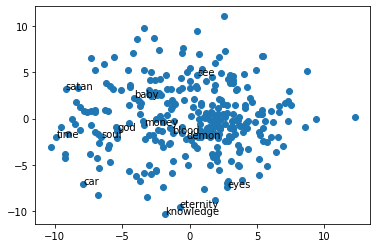

In [247]:
todos = model[vectors.vocab] #la colección total de vectores para todas las palabras en un numpy array
todos = list(todos[:300]) #elegí los primeros 100 vectores en una lista

pca = PCA(n_components=2) #cargar el modelo PCA para reducir a 2 variables 
result = pca.fit_transform(todos) #ejecutar el PCA sobre el vocabulario de vectores 

pyplot.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [248]:
#palabras del vocubalario
palabras = (list(model.wv.vocab)[20:31]) #limitar la lista, para que no muestre todas y cada una
for x in palabras:
	print (x)

god
control
rush
despair
gap
appear
beam
alienation
scapegoat
prove
genocide


<p><font size="6">Segunda visualización: t-SNE de TODO el vocabulario del modelo.</font></p>

Para que se vea mejor, habría que generar el modelo de nuevo, con las palabras que aparezcan más de, por ejemplo, 500 veces, para reducir las palabras del vocabulario. 

In [249]:
#puede demorar 1 hora 

def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    print ("cargando................")
    plt.show()
    print ("ya cargó................")
print (tsne_plot(model))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


KeyboardInterrupt: 

<p><font size="6">Tercera visualización: t-SNE sobre lista de palabras con sus sinónimos.</font></p>

La siguiente función plotea un t-SNE de palabras en una lista, añadiendo 10 sinónimos (most_similar) de cada una de las palabras de esa lista, basánadose en los vectores de cada una. <br>

Los puntos son palabras. <br>

El color es el grupo de sinónimos al que pertenecen. <br>

La distancia entre los puntos refleja la cercanía o lejanía semántica entre cada punto.<br>
Una palabra puede compartir uno de sus sinónimos, por lo tanto, una palabra podría aparecer repetida con dos colores, dado que proviene que de semillas distintas.<br>
La misma palabra debería aparecer muy cerca de sí misma.<br>


In [ ]:
keys = ['soul',
        'eachother',
        'carrousel',
        'bring',
        'somebody',
        'bye',
        'harmless',
        'envelope',
        'appeal',
        #'demon', 
        #'blood', 
        #'life',
        #'night', 
        #'god', 
        #'time', 
        #'soul', 
        'know']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in vectors.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(vectors[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=25, 
                        n_components=2, 
                        init='pca', 
                        n_iter=3500, 
                        random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()
    
tsne_plot_similar_words('Grupos de similitud entre palabras similares en Darklyrics', 
                        keys, 
                        embeddings_en_2d, 
                        word_clusters, 0.7,
                        './archivos_modelos/similar_words.png')


La siguiente función permite imprimir la información de la presente máquina, para dejar registro de la máquina en la que se hizo el procesamiento. 

In [139]:
import platform

pm = 'máquina: ' + platform.machine()
pv = 'versión: ' + platform.version()
pl = 'plataforma: ' + platform.platform()
pu = 'uname: ' + str(platform.uname())
ps = 'sistema: ' + platform.system()
pp = 'procesardor: ' + platform.processor()
caracteristicas_maquina = [pm, pv, pl, pu, ps, pp]
for x in caracteristicas_maquina:
    print ('\n',x)


 máquina: x86_64

 versión: Darwin Kernel Version 18.5.0: Mon Mar 11 20:40:32 PDT 2019; root:xnu-4903.251.3~3/RELEASE_X86_64

 plataforma: Darwin-18.5.0-x86_64-i386-64bit

 uname: uname_result(system='Darwin', node='MacBook-Pro-de-Sebastian.local', release='18.5.0', version='Darwin Kernel Version 18.5.0: Mon Mar 11 20:40:32 PDT 2019; root:xnu-4903.251.3~3/RELEASE_X86_64', machine='x86_64', processor='i386')

 sistema: Darwin

 procesardor: i386


<p><font size="6">Cuarta visualización: t-SNE en 3 dimensiones.</font></p>

Desafío pendiente 1: reducir la cantidad elementos. Aparecen las 23xxx palabras del vocabulario.
Desafío pendiente 2: permitir la interacción con el objeto tridimensional. 

<b>To Do: usar la siguiente visualización para un grupo reducido de palabras. 
    usar un subconjunto de las palabras, en vez de visualizarlas todas juntas</b><br>
    <br>

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


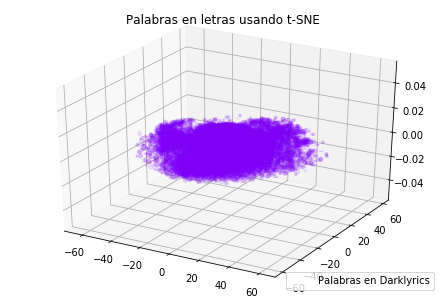

In [29]:
words_wp = []
embeddings_wp = []
for word in list(vectors.vocab):
    embeddings_wp.append(vectors[word])
    words_wp.append(word)
    
tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(embeddings_wp)

from mpl_toolkits.mplot3d import Axes3D


def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('Palabras en letras usando t-SNE', 'Palabras en Darklyrics', embeddings_wp_3d, a=0.1)